# Building your own algorithm container

With Amazon SageMaker, you can package your own algorithms that can than be trained and deployed in the SageMaker environment. This notebook will guide you through an example that shows you how to build a Docker container for SageMaker and use it for training and inference.

In [1]:
%%time
%%sh

# The name of our algorithm
algorithm_name=decision-trees

cd container

chmod +x decision_trees/train
chmod +x decision_trees/serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded

Step 1/9 : FROM ubuntu:16.04
16.04: Pulling from library/ubuntu
8ee29e426c26: Pulling fs layer
6e83b260b73b: Pulling fs layer
e26b65fd1143: Pulling fs layer
40dca07f8222: Pulling fs layer
b420ae9e10b3: Pulling fs layer
40dca07f8222: Waiting
b420ae9e10b3: Waiting
6e83b260b73b: Verifying Checksum
6e83b260b73b: Download complete
e26b65fd1143: Verifying Checksum
e26b65fd1143: Download complete
40dca07f8222: Verifying Checksum
40dca07f8222: Download complete
b420ae9e10b3: Verifying Checksum
b420ae9e10b3: Download complete
8ee29e426c26: Verifying Checksum
8ee29e426c26: Download complete
8ee29e426c26: Pull complete
6e83b260b73b: Pull complete
e26b65fd1143: Pull complete
40dca07f8222: Pull complete
b420ae9e10b3: Pull complete
Digest: sha256:3097ac92b852f878f802c22a38f97b097b4084dbef82893ba453ba0297d76a6a
Status: Downloaded newer image for ubuntu:16.04
 ---> 7aa3602ab41e
Step 2/9 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget vim          py

WARNING! Using --password via the CLI is insecure. Use --password-stdin.


CPU times: user 24 ms, sys: 8 ms, total: 32 ms
Wall time: 1min 47s


In [2]:
# S3 prefix
prefix = 'tflearn-planesnet'

# Define IAM role
import boto3
import re

import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()

In [3]:
import sagemaker as sage
from time import gmtime, strftime

sess = sage.Session()

In [4]:
!unzip -o data/planesnet.json.zip -d data

Archive:  data/planesnet.json.zip
  inflating: data/planesnet.json     


In [5]:
%%time
WORK_DIRECTORY = 'data'

data_location = sess.upload_data(WORK_DIRECTORY, key_prefix=prefix)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-754487812300


CPU times: user 1.59 s, sys: 568 ms, total: 2.16 s
Wall time: 3.56 s


In [6]:
%%time
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/decision-trees:latest'.format(account, region)

tree = sage.estimator.Estimator(image,
                       role, 1, 'ml.c5.9xlarge',
                       output_path="s3://{}/output".format(sess.default_bucket()),
                       sagemaker_session=sess)

tree.fit(data_location)

INFO:sagemaker:Creating training-job with name: decision-trees-2018-08-16-12-23-24-304


................
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
2018-08-16 12:25:47.539372: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
planesnet training  /opt/ml/input/data/training
input_file  /opt/ml/input/data/training/planesnet.json
---------------------------------
Run id: planesnet
Log directory: /tmp/tflearn_logs/
---------------------------------
Preprocessing... Calculating mean over all dataset (this may take long)...
Mean: 0.6784151790236921 (To avoid repetitive computation, add it to argument 'mean' of `add_featurewise_zero_center`)
---------------------------------
Preprocessing... Calculating std over all dataset (this may take long)...
STD: 0.1955061901344093 (To avoid repetitive computation, a

#033[A#033[ATraining Step: 200  | total loss: #033#0330.20687#033#033 | time: 8.129s
#033[2K#015| Adam | epoch: 001 | loss: 0.20687 - acc: 0.9193 | val_loss: 0.16720 - val_acc: 0.9383 -- iter: 25600/25600
--
Training Step: 201  | total loss: #033#0330.20641#033#033 | time: 0.035s
#033[2K#015| Adam | epoch: 002 | loss: 0.20641 - acc: 0.9188 -- iter: 00128/25600
#033[A#033[ATraining Step: 202  | total loss: #033#0330.20459#033#033 | time: 0.070s
#033[2K#015| Adam | epoch: 002 | loss: 0.20459 - acc: 0.9199 -- iter: 00256/25600
#033[A#033[ATraining Step: 203  | total loss: #033#0330.20906#033#033 | time: 0.105s
#033[2K#015| Adam | epoch: 002 | loss: 0.20906 - acc: 0.9185 -- iter: 00384/25600
#033[A#033[ATraining Step: 204  | total loss: #033#0330.20676#033#033 | time: 0.139s
#033[2K#015| Adam | epoch: 002 | loss: 0.20676 - acc: 0.9181 -- iter: 00512/25600
#033[A#033[ATraining Step: 205  | total loss: #033#0330.20261#033#033 | time: 0.174s
#033[2K#015| Adam | epoch: 002 | loss: 0.20261 - ac

#033[A#033[ATraining Step: 439  | total loss: #033#0330.11222#033#033 | time: 1.349s
#033[2K#015| Adam | epoch: 003 | loss: 0.11222 - acc: 0.9552 -- iter: 04992/25600
#033[A#033[ATraining Step: 440  | total loss: #033#0330.11412#033#033 | time: 1.384s
#033[2K#015| Adam | epoch: 003 | loss: 0.11412 - acc: 0.9550 -- iter: 05120/25600
#033[A#033[ATraining Step: 441  | total loss: #033#0330.11731#033#033 | time: 1.419s
#033[2K#015| Adam | epoch: 003 | loss: 0.11731 - acc: 0.9540 -- iter: 05248/25600
#033[A#033[ATraining Step: 442  | total loss: #033#0330.11564#033#033 | time: 1.453s
#033[2K#015| Adam | epoch: 003 | loss: 0.11564 - acc: 0.9531 -- iter: 05376/25600
#033[A#033[ATraining Step: 443  | total loss: #033#0330.11372#033#033 | time: 1.489s
#033[2K#015| Adam | epoch: 003 | loss: 0.11372 - acc: 0.9531 -- iter: 05504/25600
#033[A#033[ATraining Step: 444  | total loss: #033#0330.11663#033#033 | time: 1.524s
#033[2K#015| Adam | epoch: 003 | loss: 0.11663 - acc: 0.9523 -- iter: 05632/2560

#033[A#033[ATraining Step: 698  | total loss: #033#0330.10085#033#033 | time: 3.396s
#033[2K#015| Adam | epoch: 004 | loss: 0.10085 - acc: 0.9620 -- iter: 12544/25600
#033[A#033[ATraining Step: 699  | total loss: #033#0330.10205#033#033 | time: 3.431s
#033[2K#015| Adam | epoch: 004 | loss: 0.10205 - acc: 0.9603 -- iter: 12672/25600
#033[A#033[ATraining Step: 700  | total loss: #033#0330.10201#033#033 | time: 3.466s
#033[2K#015| Adam | epoch: 004 | loss: 0.10201 - acc: 0.9611 -- iter: 12800/25600
#033[A#033[ATraining Step: 701  | total loss: #033#0330.10185#033#033 | time: 3.500s
#033[2K#015| Adam | epoch: 004 | loss: 0.10185 - acc: 0.9603 -- iter: 12928/25600
#033[A#033[ATraining Step: 702  | total loss: #033#0330.09600#033#033 | time: 3.534s
#033[2K#015| Adam | epoch: 004 | loss: 0.09600 - acc: 0.9627 -- iter: 13056/25600
#033[A#033[ATraining Step: 703  | total loss: #033#0330.10343#033#033 | time: 3.569s
#033[2K#015| Adam | epoch: 004 | loss: 0.10343 - acc: 0.9587 -- iter: 13184/2560

#033[A#033[ATraining Step: 957  | total loss: #033#0330.08323#033#033 | time: 5.444s
#033[2K#015| Adam | epoch: 005 | loss: 0.08323 - acc: 0.9676 -- iter: 20096/25600
#033[A#033[ATraining Step: 958  | total loss: #033#0330.08502#033#033 | time: 5.479s
#033[2K#015| Adam | epoch: 005 | loss: 0.08502 - acc: 0.9670 -- iter: 20224/25600
#033[A#033[ATraining Step: 959  | total loss: #033#0330.08450#033#033 | time: 5.513s
#033[2K#015| Adam | epoch: 005 | loss: 0.08450 - acc: 0.9664 -- iter: 20352/25600
#033[A#033[ATraining Step: 960  | total loss: #033#0330.08029#033#033 | time: 5.547s
#033[2K#015| Adam | epoch: 005 | loss: 0.08029 - acc: 0.9682 -- iter: 20480/25600
#033[A#033[ATraining Step: 961  | total loss: #033#0330.07627#033#033 | time: 5.581s
#033[2K#015| Adam | epoch: 005 | loss: 0.07627 - acc: 0.9698 -- iter: 20608/25600
#033[A#033[ATraining Step: 962  | total loss: #033#0330.07695#033#033 | time: 5.616s
#033[2K#015| Adam | epoch: 005 | loss: 0.07695 - acc: 0.9697 -- iter: 20736/2560

#033[A#033[ATraining Step: 1331  | total loss: #033#0330.07292#033#033 | time: 4.548s
#033[2K#015| Adam | epoch: 007 | loss: 0.07292 - acc: 0.9736 -- iter: 16768/25600
#033[A#033[ATraining Step: 1332  | total loss: #033#0330.07777#033#033 | time: 4.582s
#033[2K#015| Adam | epoch: 007 | loss: 0.07777 - acc: 0.9731 -- iter: 16896/25600
#033[A#033[ATraining Step: 1333  | total loss: #033#0330.07377#033#033 | time: 4.617s
#033[2K#015| Adam | epoch: 007 | loss: 0.07377 - acc: 0.9750 -- iter: 17024/25600
#033[A#033[ATraining Step: 1334  | total loss: #033#0330.07281#033#033 | time: 4.653s
#033[2K#015| Adam | epoch: 007 | loss: 0.07281 - acc: 0.9751 -- iter: 17152/25600
#033[A#033[ATraining Step: 1335  | total loss: #033#0330.08077#033#033 | time: 4.686s
#033[2K#015| Adam | epoch: 007 | loss: 0.08077 - acc: 0.9722 -- iter: 17280/25600
#033[A#033[ATraining Step: 1336  | total loss: #033#0330.07752#033#033 | time: 4.721s
#033[2K#015| Adam | epoch: 007 | loss: 0.07752 - acc: 0.9734 -- iter: 1740

#033[A#033[ATraining Step: 1445  | total loss: #033#0330.06143#033#033 | time: 1.562s
#033[2K#015| Adam | epoch: 008 | loss: 0.06143 - acc: 0.9777 -- iter: 05760/25600
#033[A#033[ATraining Step: 1446  | total loss: #033#0330.07026#033#033 | time: 1.598s
#033[2K#015| Adam | epoch: 008 | loss: 0.07026 - acc: 0.9760 -- iter: 05888/25600
#033[A#033[ATraining Step: 1447  | total loss: #033#0330.07209#033#033 | time: 1.632s
#033[2K#015| Adam | epoch: 008 | loss: 0.07209 - acc: 0.9745 -- iter: 06016/25600
#033[A#033[ATraining Step: 1448  | total loss: #033#0330.07200#033#033 | time: 1.668s
#033[2K#015| Adam | epoch: 008 | loss: 0.07200 - acc: 0.9755 -- iter: 06144/25600
#033[A#033[ATraining Step: 1449  | total loss: #033#0330.07590#033#033 | time: 1.702s
#033[2K#015| Adam | epoch: 008 | loss: 0.07590 - acc: 0.9717 -- iter: 06272/25600
#033[A#033[ATraining Step: 1450  | total loss: #033#0330.07540#033#033 | time: 1.737s
#033[2K#015| Adam | epoch: 008 | loss: 0.07540 - acc: 0.9722 -- iter: 0640

#033[A#033[ATraining Step: 1817  | total loss: #033#0330.05937#033#033 | time: 0.595s
#033[2K#015| Adam | epoch: 010 | loss: 0.05937 - acc: 0.9810 -- iter: 02176/25600
#033[A#033[ATraining Step: 1818  | total loss: #033#0330.06216#033#033 | time: 0.630s
#033[2K#015| Adam | epoch: 010 | loss: 0.06216 - acc: 0.9782 -- iter: 02304/25600
#033[A#033[ATraining Step: 1819  | total loss: #033#0330.06714#033#033 | time: 0.665s
#033[2K#015| Adam | epoch: 010 | loss: 0.06714 - acc: 0.9757 -- iter: 02432/25600
#033[A#033[ATraining Step: 1820  | total loss: #033#0330.06790#033#033 | time: 0.700s
#033[2K#015| Adam | epoch: 010 | loss: 0.06790 - acc: 0.9766 -- iter: 02560/25600
#033[A#033[ATraining Step: 1821  | total loss: #033#0330.06834#033#033 | time: 0.734s
#033[2K#015| Adam | epoch: 010 | loss: 0.06834 - acc: 0.9742 -- iter: 02688/25600
#033[A#033[ATraining Step: 1822  | total loss: #033#0330.06820#033#033 | time: 0.770s
#033[2K#015| Adam | epoch: 010 | loss: 0.06820 - acc: 0.9745 -- iter: 0281

#033[A#033[ATraining Step: 2075  | total loss: #033#0330.05476#033#033 | time: 2.605s
#033[2K#015| Adam | epoch: 011 | loss: 0.05476 - acc: 0.9770 -- iter: 09600/25600
#033[A#033[ATraining Step: 2076  | total loss: #033#0330.05589#033#033 | time: 2.640s
#033[2K#015| Adam | epoch: 011 | loss: 0.05589 - acc: 0.9770 -- iter: 09728/25600
#033[A#033[ATraining Step: 2077  | total loss: #033#0330.05173#033#033 | time: 2.674s
#033[2K#015| Adam | epoch: 011 | loss: 0.05173 - acc: 0.9793 -- iter: 09856/25600
#033[A#033[ATraining Step: 2078  | total loss: #033#0330.05144#033#033 | time: 2.709s
#033[2K#015| Adam | epoch: 011 | loss: 0.05144 - acc: 0.9790 -- iter: 09984/25600
#033[A#033[ATraining Step: 2079  | total loss: #033#0330.05625#033#033 | time: 2.743s
#033[2K#015| Adam | epoch: 011 | loss: 0.05625 - acc: 0.9772 -- iter: 10112/25600
#033[A#033[ATraining Step: 2080  | total loss: #033#0330.05552#033#033 | time: 2.779s
#033[2K#015| Adam | epoch: 011 | loss: 0.05552 - acc: 0.9779 -- iter: 1024

#033[A#033[ATraining Step: 2332  | total loss: #033#0330.05343#033#033 | time: 4.602s
#033[2K#015| Adam | epoch: 012 | loss: 0.05343 - acc: 0.9796 -- iter: 16896/25600
#033[A#033[ATraining Step: 2333  | total loss: #033#0330.05318#033#033 | time: 4.639s
#033[2K#015| Adam | epoch: 012 | loss: 0.05318 - acc: 0.9793 -- iter: 17024/25600
#033[A#033[ATraining Step: 2334  | total loss: #033#0330.05531#033#033 | time: 4.674s
#033[2K#015| Adam | epoch: 012 | loss: 0.05531 - acc: 0.9775 -- iter: 17152/25600
#033[A#033[ATraining Step: 2335  | total loss: #033#0330.05447#033#033 | time: 4.708s
#033[2K#015| Adam | epoch: 012 | loss: 0.05447 - acc: 0.9774 -- iter: 17280/25600
#033[A#033[ATraining Step: 2336  | total loss: #033#0330.05275#033#033 | time: 4.743s
#033[2K#015| Adam | epoch: 012 | loss: 0.05275 - acc: 0.9773 -- iter: 17408/25600
#033[A#033[ATraining Step: 2337  | total loss: #033#0330.05130#033#033 | time: 4.778s
#033[2K#015| Adam | epoch: 012 | loss: 0.05130 - acc: 0.9780 -- iter: 1753

#033[A#033[ATraining Step: 2589  | total loss: #033#0330.17895#033#033 | time: 6.613s
#033[2K#015| Adam | epoch: 013 | loss: 0.17895 - acc: 0.9660 -- iter: 24192/25600
#033[A#033[ATraining Step: 2590  | total loss: #033#0330.16640#033#033 | time: 6.649s
#033[2K#015| Adam | epoch: 013 | loss: 0.16640 - acc: 0.9679 -- iter: 24320/25600
#033[A#033[ATraining Step: 2591  | total loss: #033#0330.15434#033#033 | time: 6.687s
#033[2K#015| Adam | epoch: 013 | loss: 0.15434 - acc: 0.9703 -- iter: 24448/25600
#033[A#033[ATraining Step: 2592  | total loss: #033#0330.14450#033#033 | time: 6.723s
#033[2K#015| Adam | epoch: 013 | loss: 0.14450 - acc: 0.9725 -- iter: 24576/25600
#033[A#033[ATraining Step: 2593  | total loss: #033#0330.13675#033#033 | time: 6.759s
#033[2K#015| Adam | epoch: 013 | loss: 0.13675 - acc: 0.9729 -- iter: 24704/25600
#033[A#033[ATraining Step: 2594  | total loss: #033#0330.13124#033#033 | time: 6.794s
#033[2K#015| Adam | epoch: 013 | loss: 0.13124 - acc: 0.9725 -- iter: 2483

#033[A#033[ATraining Step: 2816  | total loss: #033#0330.04843#033#033 | time: 0.560s
#033[2K#015| Adam | epoch: 015 | loss: 0.04843 - acc: 0.9863 -- iter: 02048/25600
#033[A#033[ATraining Step: 2817  | total loss: #033#0330.04942#033#033 | time: 0.595s
#033[2K#015| Adam | epoch: 015 | loss: 0.04942 - acc: 0.9854 -- iter: 02176/25600
#033[A#033[ATraining Step: 2818  | total loss: #033#0330.04741#033#033 | time: 0.628s
#033[2K#015| Adam | epoch: 015 | loss: 0.04741 - acc: 0.9853 -- iter: 02304/25600
#033[A#033[ATraining Step: 2819  | total loss: #033#0330.04722#033#033 | time: 0.663s
#033[2K#015| Adam | epoch: 015 | loss: 0.04722 - acc: 0.9860 -- iter: 02432/25600
#033[A#033[ATraining Step: 2820  | total loss: #033#0330.04819#033#033 | time: 0.697s
#033[2K#015| Adam | epoch: 015 | loss: 0.04819 - acc: 0.9842 -- iter: 02560/25600
#033[A#033[ATraining Step: 2821  | total loss: #033#0330.04993#033#033 | time: 0.732s
#033[2K#015| Adam | epoch: 015 | loss: 0.04993 - acc: 0.9835 -- iter: 0268

#033[A#033[ATraining Step: 3073  | total loss: #033#0330.05226#033#033 | time: 2.560s
#033[2K#015| Adam | epoch: 016 | loss: 0.05226 - acc: 0.9803 -- iter: 09344/25600
#033[A#033[ATraining Step: 3074  | total loss: #033#0330.05155#033#033 | time: 2.596s
#033[2K#015| Adam | epoch: 016 | loss: 0.05155 - acc: 0.9807 -- iter: 09472/25600
#033[A#033[ATraining Step: 3075  | total loss: #033#0330.04976#033#033 | time: 2.631s
#033[2K#015| Adam | epoch: 016 | loss: 0.04976 - acc: 0.9819 -- iter: 09600/25600
#033[A#033[ATraining Step: 3076  | total loss: #033#0330.04713#033#033 | time: 2.667s
#033[2K#015| Adam | epoch: 016 | loss: 0.04713 - acc: 0.9829 -- iter: 09728/25600
#033[A#033[ATraining Step: 3077  | total loss: #033#0330.04929#033#033 | time: 2.702s
#033[2K#015| Adam | epoch: 016 | loss: 0.04929 - acc: 0.9815 -- iter: 09856/25600
#033[A#033[ATraining Step: 3078  | total loss: #033#0330.04910#033#033 | time: 2.736s
#033[2K#015| Adam | epoch: 016 | loss: 0.04910 - acc: 0.9825 -- iter: 0998

#033[A#033[ATraining Step: 3331  | total loss: #033#0330.04964#033#033 | time: 4.551s
#033[2K#015| Adam | epoch: 017 | loss: 0.04964 - acc: 0.9813 -- iter: 16768/25600
#033[A#033[ATraining Step: 3332  | total loss: #033#0330.04761#033#033 | time: 4.585s
#033[2K#015| Adam | epoch: 017 | loss: 0.04761 - acc: 0.9823 -- iter: 16896/25600
#033[A#033[ATraining Step: 3333  | total loss: #033#0330.04482#033#033 | time: 4.620s
#033[2K#015| Adam | epoch: 017 | loss: 0.04482 - acc: 0.9841 -- iter: 17024/25600
#033[A#033[ATraining Step: 3334  | total loss: #033#0330.04509#033#033 | time: 4.654s
#033[2K#015| Adam | epoch: 017 | loss: 0.04509 - acc: 0.9834 -- iter: 17152/25600
#033[A#033[ATraining Step: 3335  | total loss: #033#0330.04577#033#033 | time: 4.689s
#033[2K#015| Adam | epoch: 017 | loss: 0.04577 - acc: 0.9835 -- iter: 17280/25600
#033[A#033[ATraining Step: 3336  | total loss: #033#0330.05446#033#033 | time: 4.722s
#033[2K#015| Adam | epoch: 017 | loss: 0.05446 - acc: 0.9796 -- iter: 1740

#033[A#033[ATraining Step: 3588  | total loss: #033#0330.25255#033#033 | time: 6.547s
#033[2K#015| Adam | epoch: 018 | loss: 0.25255 - acc: 0.9626 -- iter: 24064/25600
#033[A#033[ATraining Step: 3589  | total loss: #033#0330.23062#033#033 | time: 6.582s
#033[2K#015| Adam | epoch: 018 | loss: 0.23062 - acc: 0.9647 -- iter: 24192/25600
#033[A#033[ATraining Step: 3590  | total loss: #033#0330.21248#033#033 | time: 6.615s
#033[2K#015| Adam | epoch: 018 | loss: 0.21248 - acc: 0.9667 -- iter: 24320/25600
#033[A#033[ATraining Step: 3591  | total loss: #033#0330.19805#033#033 | time: 6.650s
#033[2K#015| Adam | epoch: 018 | loss: 0.19805 - acc: 0.9661 -- iter: 24448/25600
#033[A#033[ATraining Step: 3592  | total loss: #033#0330.18643#033#033 | time: 6.684s
#033[2K#015| Adam | epoch: 018 | loss: 0.18643 - acc: 0.9633 -- iter: 24576/25600
#033[A#033[ATraining Step: 3593  | total loss: #033#0330.17514#033#033 | time: 6.719s
#033[2K#015| Adam | epoch: 018 | loss: 0.17514 - acc: 0.9646 -- iter: 2470

#033[A#033[ATraining Step: 3816  | total loss: #033#0330.06052#033#033 | time: 0.560s
#033[2K#015| Adam | epoch: 020 | loss: 0.06052 - acc: 0.9838 -- iter: 02048/25600
#033[A#033[ATraining Step: 3817  | total loss: #033#0330.05742#033#033 | time: 0.594s
#033[2K#015| Adam | epoch: 020 | loss: 0.05742 - acc: 0.9839 -- iter: 02176/25600
#033[A#033[ATraining Step: 3818  | total loss: #033#0330.05425#033#033 | time: 0.629s
#033[2K#015| Adam | epoch: 020 | loss: 0.05425 - acc: 0.9847 -- iter: 02304/25600
#033[A#033[ATraining Step: 3819  | total loss: #033#0330.05467#033#033 | time: 0.664s
#033[2K#015| Adam | epoch: 020 | loss: 0.05467 - acc: 0.9847 -- iter: 02432/25600
#033[A#033[ATraining Step: 3820  | total loss: #033#0330.05184#033#033 | time: 0.699s
#033[2K#015| Adam | epoch: 020 | loss: 0.05184 - acc: 0.9854 -- iter: 02560/25600
#033[A#033[ATraining Step: 3821  | total loss: #033#0330.05095#033#033 | time: 0.733s
#033[2K#015| Adam | epoch: 020 | loss: 0.05095 - acc: 0.9853 -- iter: 0268

#033[A#033[ATraining Step: 4073  | total loss: #033#0330.02976#033#033 | time: 2.540s
#033[2K#015| Adam | epoch: 021 | loss: 0.02976 - acc: 0.9897 -- iter: 09344/25600
#033[A#033[ATraining Step: 4074  | total loss: #033#0330.02914#033#033 | time: 2.574s
#033[2K#015| Adam | epoch: 021 | loss: 0.02914 - acc: 0.9891 -- iter: 09472/25600
#033[A#033[ATraining Step: 4075  | total loss: #033#0330.03659#033#033 | time: 2.609s
#033[2K#015| Adam | epoch: 021 | loss: 0.03659 - acc: 0.9879 -- iter: 09600/25600
#033[A#033[ATraining Step: 4076  | total loss: #033#0330.03584#033#033 | time: 2.644s
#033[2K#015| Adam | epoch: 021 | loss: 0.03584 - acc: 0.9875 -- iter: 09728/25600
#033[A#033[ATraining Step: 4077  | total loss: #033#0330.03796#033#033 | time: 2.679s
#033[2K#015| Adam | epoch: 021 | loss: 0.03796 - acc: 0.9864 -- iter: 09856/25600
#033[A#033[ATraining Step: 4078  | total loss: #033#0330.03817#033#033 | time: 2.713s
#033[2K#015| Adam | epoch: 021 | loss: 0.03817 - acc: 0.9855 -- iter: 0998

#033[A#033[ATraining Step: 4330  | total loss: #033#0330.02808#033#033 | time: 4.537s
#033[2K#015| Adam | epoch: 022 | loss: 0.02808 - acc: 0.9905 -- iter: 16640/25600
#033[A#033[ATraining Step: 4331  | total loss: #033#0330.02835#033#033 | time: 4.573s
#033[2K#015| Adam | epoch: 022 | loss: 0.02835 - acc: 0.9899 -- iter: 16768/25600
#033[A#033[ATraining Step: 4332  | total loss: #033#0330.02857#033#033 | time: 4.607s
#033[2K#015| Adam | epoch: 022 | loss: 0.02857 - acc: 0.9901 -- iter: 16896/25600
#033[A#033[ATraining Step: 4333  | total loss: #033#0330.03064#033#033 | time: 4.643s
#033[2K#015| Adam | epoch: 022 | loss: 0.03064 - acc: 0.9880 -- iter: 17024/25600
#033[A#033[ATraining Step: 4334  | total loss: #033#0330.02862#033#033 | time: 4.678s
#033[2K#015| Adam | epoch: 022 | loss: 0.02862 - acc: 0.9884 -- iter: 17152/25600
#033[A#033[ATraining Step: 4335  | total loss: #033#0330.03044#033#033 | time: 4.712s
#033[2K#015| Adam | epoch: 022 | loss: 0.03044 - acc: 0.9880 -- iter: 1728

#033[A#033[ATraining Step: 4588  | total loss: #033#0330.03671#033#033 | time: 6.507s
#033[2K#015| Adam | epoch: 023 | loss: 0.03671 - acc: 0.9875 -- iter: 24064/25600
#033[A#033[ATraining Step: 4589  | total loss: #033#0330.03541#033#033 | time: 6.542s
#033[2K#015| Adam | epoch: 023 | loss: 0.03541 - acc: 0.9880 -- iter: 24192/25600
#033[A#033[ATraining Step: 4590  | total loss: #033#0330.03864#033#033 | time: 6.577s
#033[2K#015| Adam | epoch: 023 | loss: 0.03864 - acc: 0.9869 -- iter: 24320/25600
#033[A#033[ATraining Step: 4591  | total loss: #033#0330.24914#033#033 | time: 6.611s
#033[2K#015| Adam | epoch: 023 | loss: 0.24914 - acc: 0.9655 -- iter: 24448/25600
#033[A#033[ATraining Step: 4592  | total loss: #033#0330.22616#033#033 | time: 6.646s
#033[2K#015| Adam | epoch: 023 | loss: 0.22616 - acc: 0.9682 -- iter: 24576/25600
#033[A#033[ATraining Step: 4593  | total loss: #033#0330.20856#033#033 | time: 6.681s
#033[2K#015| Adam | epoch: 023 | loss: 0.20856 - acc: 0.9682 -- iter: 2470

#033[A#033[ATraining Step: 4816  | total loss: #033#0330.07050#033#033 | time: 0.556s
#033[2K#015| Adam | epoch: 025 | loss: 0.07050 - acc: 0.9833 -- iter: 02048/25600
#033[A#033[ATraining Step: 4817  | total loss: #033#0330.06648#033#033 | time: 0.591s
#033[2K#015| Adam | epoch: 025 | loss: 0.06648 - acc: 0.9842 -- iter: 02176/25600
#033[A#033[ATraining Step: 4818  | total loss: #033#0330.06217#033#033 | time: 0.625s
#033[2K#015| Adam | epoch: 025 | loss: 0.06217 - acc: 0.9850 -- iter: 02304/25600
#033[A#033[ATraining Step: 4819  | total loss: #033#0330.05975#033#033 | time: 0.661s
#033[2K#015| Adam | epoch: 025 | loss: 0.05975 - acc: 0.9841 -- iter: 02432/25600
#033[A#033[ATraining Step: 4820  | total loss: #033#0330.06014#033#033 | time: 0.695s
#033[2K#015| Adam | epoch: 025 | loss: 0.06014 - acc: 0.9834 -- iter: 02560/25600
#033[A#033[ATraining Step: 4821  | total loss: #033#0330.05573#033#033 | time: 0.729s
#033[2K#015| Adam | epoch: 025 | loss: 0.05573 - acc: 0.9850 -- iter: 0268

#033[A#033[ATraining Step: 5074  | total loss: #033#0330.02502#033#033 | time: 2.572s
#033[2K#015| Adam | epoch: 026 | loss: 0.02502 - acc: 0.9920 -- iter: 09472/25600
#033[A#033[ATraining Step: 5075  | total loss: #033#0330.02394#033#033 | time: 2.607s
#033[2K#015| Adam | epoch: 026 | loss: 0.02394 - acc: 0.9920 -- iter: 09600/25600
#033[A#033[ATraining Step: 5076  | total loss: #033#0330.02332#033#033 | time: 2.641s
#033[2K#015| Adam | epoch: 026 | loss: 0.02332 - acc: 0.9928 -- iter: 09728/25600
#033[A#033[ATraining Step: 5077  | total loss: #033#0330.02448#033#033 | time: 2.676s
#033[2K#015| Adam | epoch: 026 | loss: 0.02448 - acc: 0.9927 -- iter: 09856/25600
#033[A#033[ATraining Step: 5078  | total loss: #033#0330.02564#033#033 | time: 2.710s
#033[2K#015| Adam | epoch: 026 | loss: 0.02564 - acc: 0.9919 -- iter: 09984/25600
#033[A#033[ATraining Step: 5079  | total loss: #033#0330.02989#033#033 | time: 2.746s
#033[2K#015| Adam | epoch: 026 | loss: 0.02989 - acc: 0.9904 -- iter: 1011

#033[A#033[ATraining Step: 5332  | total loss: #033#0330.03818#033#033 | time: 4.605s
#033[2K#015| Adam | epoch: 027 | loss: 0.03818 - acc: 0.9862 -- iter: 16896/25600
#033[A#033[ATraining Step: 5333  | total loss: #033#0330.04112#033#033 | time: 4.641s
#033[2K#015| Adam | epoch: 027 | loss: 0.04112 - acc: 0.9852 -- iter: 17024/25600
#033[A#033[ATraining Step: 5334  | total loss: #033#0330.03986#033#033 | time: 4.676s
#033[2K#015| Adam | epoch: 027 | loss: 0.03986 - acc: 0.9851 -- iter: 17152/25600
#033[A#033[ATraining Step: 5335  | total loss: #033#0330.04025#033#033 | time: 4.710s
#033[2K#015| Adam | epoch: 027 | loss: 0.04025 - acc: 0.9850 -- iter: 17280/25600
#033[A#033[ATraining Step: 5336  | total loss: #033#0330.04073#033#033 | time: 4.743s
#033[2K#015| Adam | epoch: 027 | loss: 0.04073 - acc: 0.9850 -- iter: 17408/25600
#033[A#033[ATraining Step: 5337  | total loss: #033#0330.03803#033#033 | time: 4.778s
#033[2K#015| Adam | epoch: 027 | loss: 0.03803 - acc: 0.9857 -- iter: 1753

#033[A#033[ATraining Step: 5589  | total loss: #033#0330.03562#033#033 | time: 6.601s
#033[2K#015| Adam | epoch: 028 | loss: 0.03562 - acc: 0.9890 -- iter: 24192/25600
#033[A#033[ATraining Step: 5590  | total loss: #033#0330.03344#033#033 | time: 6.636s
#033[2K#015| Adam | epoch: 028 | loss: 0.03344 - acc: 0.9893 -- iter: 24320/25600
#033[A#033[ATraining Step: 5591  | total loss: #033#0330.03131#033#033 | time: 6.670s
#033[2K#015| Adam | epoch: 028 | loss: 0.03131 - acc: 0.9904 -- iter: 24448/25600
#033[A#033[ATraining Step: 5592  | total loss: #033#0330.03526#033#033 | time: 6.705s
#033[2K#015| Adam | epoch: 028 | loss: 0.03526 - acc: 0.9906 -- iter: 24576/25600
#033[A#033[ATraining Step: 5593  | total loss: #033#0330.03316#033#033 | time: 6.741s
#033[2K#015| Adam | epoch: 028 | loss: 0.03316 - acc: 0.9915 -- iter: 24704/25600
#033[A#033[ATraining Step: 5594  | total loss: #033#0330.03478#033#033 | time: 6.776s
#033[2K#015| Adam | epoch: 028 | loss: 0.03478 - acc: 0.9900 -- iter: 2483

#033[A#033[ATraining Step: 5817  | total loss: #033#0330.09491#033#033 | time: 0.592s
#033[2K#015| Adam | epoch: 030 | loss: 0.09491 - acc: 0.9856 -- iter: 02176/25600
#033[A#033[ATraining Step: 5818  | total loss: #033#0330.08757#033#033 | time: 0.627s
#033[2K#015| Adam | epoch: 030 | loss: 0.08757 - acc: 0.9871 -- iter: 02304/25600
#033[A#033[ATraining Step: 5819  | total loss: #033#0330.08236#033#033 | time: 0.662s
#033[2K#015| Adam | epoch: 030 | loss: 0.08236 - acc: 0.9884 -- iter: 02432/25600
#033[A#033[ATraining Step: 5820  | total loss: #033#0330.07742#033#033 | time: 0.697s
#033[2K#015| Adam | epoch: 030 | loss: 0.07742 - acc: 0.9888 -- iter: 02560/25600
#033[A#033[ATraining Step: 5821  | total loss: #033#0330.07135#033#033 | time: 0.731s
#033[2K#015| Adam | epoch: 030 | loss: 0.07135 - acc: 0.9899 -- iter: 02688/25600
#033[A#033[ATraining Step: 5822  | total loss: #033#0330.06655#033#033 | time: 0.766s
#033[2K#015| Adam | epoch: 030 | loss: 0.06655 - acc: 0.9901 -- iter: 0281

#033[A#033[ATraining Step: 6200  | total loss: #033#0330.35744#033#033 | time: 7.968s
#033[2K#015| Adam | epoch: 031 | loss: 0.35744 - acc: 0.9570 | val_loss: 0.05735 - val_acc: 0.9820 -- iter: 25600/25600
--
Training Step: 6201  | total loss: #033#0330.32364#033#033 | time: 0.034s
#033[2K#015| Adam | epoch: 032 | loss: 0.32364 - acc: 0.9605 -- iter: 00128/25600
#033[A#033[ATraining Step: 6202  | total loss: #033#0330.29657#033#033 | time: 0.068s
#033[2K#015| Adam | epoch: 032 | loss: 0.29657 - acc: 0.9629 -- iter: 00256/25600
#033[A#033[ATraining Step: 6203  | total loss: #033#0330.27183#033#033 | time: 0.103s
#033[2K#015| Adam | epoch: 032 | loss: 0.27183 - acc: 0.9650 -- iter: 00384/25600
#033[A#033[ATraining Step: 6204  | total loss: #033#0330.25193#033#033 | time: 0.137s
#033[2K#015| Adam | epoch: 032 | loss: 0.25193 - acc: 0.9654 -- iter: 00512/25600
#033[A#033[ATraining Step: 6205  | total loss: #033#0330.23527#033#033 | time: 0.171s
#033[2K#015| Adam | epoch: 032 | loss: 0.2352

#033[A#033[ATraining Step: 6448  | total loss: #033#0330.03350#033#033 | time: 1.672s
#033[2K#015| Adam | epoch: 033 | loss: 0.03350 - acc: 0.9921 -- iter: 06144/25600
#033[A#033[ATraining Step: 6449  | total loss: #033#0330.03121#033#033 | time: 1.706s
#033[2K#015| Adam | epoch: 033 | loss: 0.03121 - acc: 0.9929 -- iter: 06272/25600
#033[A#033[ATraining Step: 6450  | total loss: #033#0330.03651#033#033 | time: 1.741s
#033[2K#015| Adam | epoch: 033 | loss: 0.03651 - acc: 0.9928 -- iter: 06400/25600
#033[A#033[ATraining Step: 6451  | total loss: #033#0330.03519#033#033 | time: 1.776s
#033[2K#015| Adam | epoch: 033 | loss: 0.03519 - acc: 0.9927 -- iter: 06528/25600
#033[A#033[ATraining Step: 6452  | total loss: #033#0330.03673#033#033 | time: 1.811s
#033[2K#015| Adam | epoch: 033 | loss: 0.03673 - acc: 0.9896 -- iter: 06656/25600
#033[A#033[ATraining Step: 6453  | total loss: #033#0330.03640#033#033 | time: 1.846s
#033[2K#015| Adam | epoch: 033 | loss: 0.03640 - acc: 0.9890 -- iter: 0678

#033[A#033[ATraining Step: 6705  | total loss: #033#0330.02607#033#033 | time: 3.657s
#033[2K#015| Adam | epoch: 034 | loss: 0.02607 - acc: 0.9906 -- iter: 13440/25600
#033[A#033[ATraining Step: 6706  | total loss: #033#0330.02420#033#033 | time: 3.692s
#033[2K#015| Adam | epoch: 034 | loss: 0.02420 - acc: 0.9915 -- iter: 13568/25600
#033[A#033[ATraining Step: 6707  | total loss: #033#0330.02305#033#033 | time: 3.728s
#033[2K#015| Adam | epoch: 034 | loss: 0.02305 - acc: 0.9916 -- iter: 13696/25600
#033[A#033[ATraining Step: 6708  | total loss: #033#0330.02123#033#033 | time: 3.763s
#033[2K#015| Adam | epoch: 034 | loss: 0.02123 - acc: 0.9924 -- iter: 13824/25600
#033[A#033[ATraining Step: 6709  | total loss: #033#0330.01998#033#033 | time: 3.799s
#033[2K#015| Adam | epoch: 034 | loss: 0.01998 - acc: 0.9932 -- iter: 13952/25600
#033[A#033[ATraining Step: 6710  | total loss: #033#0330.02011#033#033 | time: 3.833s
#033[2K#015| Adam | epoch: 034 | loss: 0.02011 - acc: 0.9939 -- iter: 1408

#033[A#033[ATraining Step: 6963  | total loss: #033#0330.02359#033#033 | time: 5.650s
#033[2K#015| Adam | epoch: 035 | loss: 0.02359 - acc: 0.9890 -- iter: 20864/25600
#033[A#033[ATraining Step: 6964  | total loss: #033#0330.02366#033#033 | time: 5.685s
#033[2K#015| Adam | epoch: 035 | loss: 0.02366 - acc: 0.9893 -- iter: 20992/25600
#033[A#033[ATraining Step: 6965  | total loss: #033#0330.02201#033#033 | time: 5.720s
#033[2K#015| Adam | epoch: 035 | loss: 0.02201 - acc: 0.9904 -- iter: 21120/25600
#033[A#033[ATraining Step: 6966  | total loss: #033#0330.02173#033#033 | time: 5.755s
#033[2K#015| Adam | epoch: 035 | loss: 0.02173 - acc: 0.9898 -- iter: 21248/25600
#033[A#033[ATraining Step: 6967  | total loss: #033#0330.02157#033#033 | time: 5.791s
#033[2K#015| Adam | epoch: 035 | loss: 0.02157 - acc: 0.9900 -- iter: 21376/25600
#033[A#033[ATraining Step: 6968  | total loss: #033#0330.02153#033#033 | time: 5.825s
#033[2K#015| Adam | epoch: 035 | loss: 0.02153 - acc: 0.9902 -- iter: 2150

#033[A#033[ATraining Step: 7200  | total loss: #033#0330.03044#033#033 | time: 8.007s
#033[2K#015| Adam | epoch: 036 | loss: 0.03044 - acc: 0.9922 | val_loss: 0.03640 - val_acc: 0.9872 -- iter: 25600/25600
--
Training Step: 7201  | total loss: #033#0330.02959#033#033 | time: 0.035s
#033[2K#015| Adam | epoch: 037 | loss: 0.02959 - acc: 0.9914 -- iter: 00128/25600
#033[A#033[ATraining Step: 7202  | total loss: #033#0330.02683#033#033 | time: 0.070s
#033[2K#015| Adam | epoch: 037 | loss: 0.02683 - acc: 0.9922 -- iter: 00256/25600
#033[A#033[ATraining Step: 7203  | total loss: #033#0330.02538#033#033 | time: 0.104s
#033[2K#015| Adam | epoch: 037 | loss: 0.02538 - acc: 0.9922 -- iter: 00384/25600
#033[A#033[ATraining Step: 7204  | total loss: #033#0330.35196#033#033 | time: 0.141s
#033[2K#015| Adam | epoch: 037 | loss: 0.35196 - acc: 0.9579 -- iter: 00512/25600
#033[A#033[ATraining Step: 7205  | total loss: #033#0330.32016#033#033 | time: 0.177s
#033[2K#015| Adam | epoch: 037 | loss: 0.3201

#033[A#033[ATraining Step: 7447  | total loss: #033#0330.02923#033#033 | time: 1.639s
#033[2K#015| Adam | epoch: 038 | loss: 0.02923 - acc: 0.9933 -- iter: 06016/25600
#033[A#033[ATraining Step: 7448  | total loss: #033#0330.02761#033#033 | time: 1.674s
#033[2K#015| Adam | epoch: 038 | loss: 0.02761 - acc: 0.9939 -- iter: 06144/25600
#033[A#033[ATraining Step: 7449  | total loss: #033#0330.02753#033#033 | time: 1.708s
#033[2K#015| Adam | epoch: 038 | loss: 0.02753 - acc: 0.9930 -- iter: 06272/25600
#033[A#033[ATraining Step: 7450  | total loss: #033#0330.02805#033#033 | time: 1.743s
#033[2K#015| Adam | epoch: 038 | loss: 0.02805 - acc: 0.9929 -- iter: 06400/25600
#033[A#033[ATraining Step: 7451  | total loss: #033#0330.02614#033#033 | time: 1.778s
#033[2K#015| Adam | epoch: 038 | loss: 0.02614 - acc: 0.9936 -- iter: 06528/25600
#033[A#033[ATraining Step: 7452  | total loss: #033#0330.02670#033#033 | time: 1.813s
#033[2K#015| Adam | epoch: 038 | loss: 0.02670 - acc: 0.9927 -- iter: 0665

#033[A#033[ATraining Step: 7705  | total loss: #033#0330.02432#033#033 | time: 3.647s
#033[2K#015| Adam | epoch: 039 | loss: 0.02432 - acc: 0.9915 -- iter: 13440/25600
#033[A#033[ATraining Step: 7706  | total loss: #033#0330.02697#033#033 | time: 3.682s
#033[2K#015| Adam | epoch: 039 | loss: 0.02697 - acc: 0.9907 -- iter: 13568/25600
#033[A#033[ATraining Step: 7707  | total loss: #033#0330.02490#033#033 | time: 3.716s
#033[2K#015| Adam | epoch: 039 | loss: 0.02490 - acc: 0.9917 -- iter: 13696/25600
#033[A#033[ATraining Step: 7708  | total loss: #033#0330.02336#033#033 | time: 3.752s
#033[2K#015| Adam | epoch: 039 | loss: 0.02336 - acc: 0.9925 -- iter: 13824/25600
#033[A#033[ATraining Step: 7709  | total loss: #033#0330.02273#033#033 | time: 3.788s
#033[2K#015| Adam | epoch: 039 | loss: 0.02273 - acc: 0.9925 -- iter: 13952/25600
#033[A#033[ATraining Step: 7710  | total loss: #033#0330.02201#033#033 | time: 3.823s
#033[2K#015| Adam | epoch: 039 | loss: 0.02201 - acc: 0.9917 -- iter: 1408

#033[A#033[ATraining Step: 7963  | total loss: #033#0330.02816#033#033 | time: 5.673s
#033[2K#015| Adam | epoch: 040 | loss: 0.02816 - acc: 0.9889 -- iter: 20864/25600
#033[A#033[ATraining Step: 7964  | total loss: #033#0330.02866#033#033 | time: 5.707s
#033[2K#015| Adam | epoch: 040 | loss: 0.02866 - acc: 0.9877 -- iter: 20992/25600
#033[A#033[ATraining Step: 7965  | total loss: #033#0330.02717#033#033 | time: 5.742s
#033[2K#015| Adam | epoch: 040 | loss: 0.02717 - acc: 0.9881 -- iter: 21120/25600
#033[A#033[ATraining Step: 7966  | total loss: #033#0330.02513#033#033 | time: 5.776s
#033[2K#015| Adam | epoch: 040 | loss: 0.02513 - acc: 0.9893 -- iter: 21248/25600
#033[A#033[ATraining Step: 7967  | total loss: #033#0330.02421#033#033 | time: 5.810s
#033[2K#015| Adam | epoch: 040 | loss: 0.02421 - acc: 0.9896 -- iter: 21376/25600
#033[A#033[ATraining Step: 7968  | total loss: #033#0330.02240#033#033 | time: 5.845s
#033[2K#015| Adam | epoch: 040 | loss: 0.02240 - acc: 0.9906 -- iter: 2150

#033[A#033[ATraining Step: 8200  | total loss: #033#0330.02280#033#033 | time: 8.001s
#033[2K#015| Adam | epoch: 041 | loss: 0.02280 - acc: 0.9924 | val_loss: 0.03845 - val_acc: 0.9888 -- iter: 25600/25600
--
Training Step: 8201  | total loss: #033#0330.02094#033#033 | time: 0.035s
#033[2K#015| Adam | epoch: 042 | loss: 0.02094 - acc: 0.9931 -- iter: 00128/25600
#033[A#033[ATraining Step: 8202  | total loss: #033#0330.02145#033#033 | time: 0.069s
#033[2K#015| Adam | epoch: 042 | loss: 0.02145 - acc: 0.9930 -- iter: 00256/25600
#033[A#033[ATraining Step: 8203  | total loss: #033#0330.02029#033#033 | time: 0.107s
#033[2K#015| Adam | epoch: 042 | loss: 0.02029 - acc: 0.9937 -- iter: 00384/25600
#033[A#033[ATraining Step: 8204  | total loss: #033#0330.01863#033#033 | time: 0.141s
#033[2K#015| Adam | epoch: 042 | loss: 0.01863 - acc: 0.9944 -- iter: 00512/25600
#033[A#033[ATraining Step: 8205  | total loss: #033#0330.02293#033#033 | time: 0.175s
#033[2K#015| Adam | epoch: 042 | loss: 0.0229

#033[A#033[ATraining Step: 8448  | total loss: #033#0330.04112#033#033 | time: 1.668s
#033[2K#015| Adam | epoch: 043 | loss: 0.04112 - acc: 0.9879 -- iter: 06144/25600
#033[A#033[ATraining Step: 8449  | total loss: #033#0330.04111#033#033 | time: 1.702s
#033[2K#015| Adam | epoch: 043 | loss: 0.04111 - acc: 0.9875 -- iter: 06272/25600
#033[A#033[ATraining Step: 8450  | total loss: #033#0330.04059#033#033 | time: 1.737s
#033[2K#015| Adam | epoch: 043 | loss: 0.04059 - acc: 0.9872 -- iter: 06400/25600
#033[A#033[ATraining Step: 8451  | total loss: #033#0330.03998#033#033 | time: 1.771s
#033[2K#015| Adam | epoch: 043 | loss: 0.03998 - acc: 0.9869 -- iter: 06528/25600
#033[A#033[ATraining Step: 8452  | total loss: #033#0330.03808#033#033 | time: 1.806s
#033[2K#015| Adam | epoch: 043 | loss: 0.03808 - acc: 0.9882 -- iter: 06656/25600
#033[A#033[ATraining Step: 8453  | total loss: #033#0330.03578#033#033 | time: 1.841s
#033[2K#015| Adam | epoch: 043 | loss: 0.03578 - acc: 0.9894 -- iter: 0678

#033[A#033[ATraining Step: 8706  | total loss: #033#0330.02763#033#033 | time: 3.697s
#033[2K#015| Adam | epoch: 044 | loss: 0.02763 - acc: 0.9901 -- iter: 13568/25600
#033[A#033[ATraining Step: 8707  | total loss: #033#0330.02587#033#033 | time: 3.733s
#033[2K#015| Adam | epoch: 044 | loss: 0.02587 - acc: 0.9911 -- iter: 13696/25600
#033[A#033[ATraining Step: 8708  | total loss: #033#0330.02614#033#033 | time: 3.767s
#033[2K#015| Adam | epoch: 044 | loss: 0.02614 - acc: 0.9905 -- iter: 13824/25600
#033[A#033[ATraining Step: 8709  | total loss: #033#0330.02693#033#033 | time: 3.802s
#033[2K#015| Adam | epoch: 044 | loss: 0.02693 - acc: 0.9898 -- iter: 13952/25600
#033[A#033[ATraining Step: 8710  | total loss: #033#0330.02692#033#033 | time: 3.836s
#033[2K#015| Adam | epoch: 044 | loss: 0.02692 - acc: 0.9893 -- iter: 14080/25600
#033[A#033[ATraining Step: 8711  | total loss: #033#0330.02562#033#033 | time: 3.871s
#033[2K#015| Adam | epoch: 044 | loss: 0.02562 - acc: 0.9896 -- iter: 1420

#033[A#033[ATraining Step: 8963  | total loss: #033#0330.02981#033#033 | time: 5.670s
#033[2K#015| Adam | epoch: 045 | loss: 0.02981 - acc: 0.9883 -- iter: 20864/25600
#033[A#033[ATraining Step: 8964  | total loss: #033#0330.02857#033#033 | time: 5.705s
#033[2K#015| Adam | epoch: 045 | loss: 0.02857 - acc: 0.9895 -- iter: 20992/25600
#033[A#033[ATraining Step: 8965  | total loss: #033#0330.02665#033#033 | time: 5.740s
#033[2K#015| Adam | epoch: 045 | loss: 0.02665 - acc: 0.9905 -- iter: 21120/25600
#033[A#033[ATraining Step: 8966  | total loss: #033#0330.02693#033#033 | time: 5.775s
#033[2K#015| Adam | epoch: 045 | loss: 0.02693 - acc: 0.9907 -- iter: 21248/25600
#033[A#033[ATraining Step: 8967  | total loss: #033#0330.02893#033#033 | time: 5.810s
#033[2K#015| Adam | epoch: 045 | loss: 0.02893 - acc: 0.9893 -- iter: 21376/25600
#033[A#033[ATraining Step: 8968  | total loss: #033#0330.02882#033#033 | time: 5.844s
#033[2K#015| Adam | epoch: 045 | loss: 0.02882 - acc: 0.9888 -- iter: 2150

#033[A#033[ATraining Step: 9200  | total loss: #033#0330.02235#033#033 | time: 8.030s
#033[2K#015| Adam | epoch: 046 | loss: 0.02235 - acc: 0.9942 | val_loss: 0.03342 - val_acc: 0.9905 -- iter: 25600/25600
--
Training Step: 9201  | total loss: #033#0330.02684#033#033 | time: 0.035s
#033[2K#015| Adam | epoch: 047 | loss: 0.02684 - acc: 0.9924 -- iter: 00128/25600
#033[A#033[ATraining Step: 9202  | total loss: #033#0330.02522#033#033 | time: 0.071s
#033[2K#015| Adam | epoch: 047 | loss: 0.02522 - acc: 0.9932 -- iter: 00256/25600
#033[A#033[ATraining Step: 9203  | total loss: #033#0330.02421#033#033 | time: 0.105s
#033[2K#015| Adam | epoch: 047 | loss: 0.02421 - acc: 0.9931 -- iter: 00384/25600
#033[A#033[ATraining Step: 9204  | total loss: #033#0330.02392#033#033 | time: 0.140s
#033[2K#015| Adam | epoch: 047 | loss: 0.02392 - acc: 0.9930 -- iter: 00512/25600
#033[A#033[ATraining Step: 9205  | total loss: #033#0330.02199#033#033 | time: 0.174s
#033[2K#015| Adam | epoch: 047 | loss: 0.0219

#033[A#033[ATraining Step: 9447  | total loss: #033#0330.04323#033#033 | time: 1.643s
#033[2K#015| Adam | epoch: 048 | loss: 0.04323 - acc: 0.9893 -- iter: 06016/25600
#033[A#033[ATraining Step: 9448  | total loss: #033#0330.04028#033#033 | time: 1.677s
#033[2K#015| Adam | epoch: 048 | loss: 0.04028 - acc: 0.9904 -- iter: 06144/25600
#033[A#033[ATraining Step: 9449  | total loss: #033#0330.03840#033#033 | time: 1.710s
#033[2K#015| Adam | epoch: 048 | loss: 0.03840 - acc: 0.9913 -- iter: 06272/25600
#033[A#033[ATraining Step: 9450  | total loss: #033#0330.03597#033#033 | time: 1.745s
#033[2K#015| Adam | epoch: 048 | loss: 0.03597 - acc: 0.9922 -- iter: 06400/25600
#033[A#033[ATraining Step: 9451  | total loss: #033#0330.03428#033#033 | time: 1.779s
#033[2K#015| Adam | epoch: 048 | loss: 0.03428 - acc: 0.9930 -- iter: 06528/25600
#033[A#033[ATraining Step: 9452  | total loss: #033#0330.03169#033#033 | time: 1.814s
#033[2K#015| Adam | epoch: 048 | loss: 0.03169 - acc: 0.9937 -- iter: 0665

#033[A#033[ATraining Step: 9704  | total loss: #033#0330.01803#033#033 | time: 3.625s
#033[2K#015| Adam | epoch: 049 | loss: 0.01803 - acc: 0.9949 -- iter: 13312/25600
#033[A#033[ATraining Step: 9705  | total loss: #033#0330.01829#033#033 | time: 3.661s
#033[2K#015| Adam | epoch: 049 | loss: 0.01829 - acc: 0.9946 -- iter: 13440/25600
#033[A#033[ATraining Step: 9706  | total loss: #033#0330.01716#033#033 | time: 3.696s
#033[2K#015| Adam | epoch: 049 | loss: 0.01716 - acc: 0.9952 -- iter: 13568/25600
#033[A#033[ATraining Step: 9707  | total loss: #033#0330.02339#033#033 | time: 3.730s
#033[2K#015| Adam | epoch: 049 | loss: 0.02339 - acc: 0.9941 -- iter: 13696/25600
#033[A#033[ATraining Step: 9708  | total loss: #033#0330.02766#033#033 | time: 3.765s
#033[2K#015| Adam | epoch: 049 | loss: 0.02766 - acc: 0.9923 -- iter: 13824/25600
#033[A#033[ATraining Step: 9709  | total loss: #033#0330.02709#033#033 | time: 3.800s
#033[2K#015| Adam | epoch: 049 | loss: 0.02709 - acc: 0.9923 -- iter: 1395

#033[A#033[ATraining Step: 9961  | total loss: #033#0330.02385#033#033 | time: 5.616s
#033[2K#015| Adam | epoch: 050 | loss: 0.02385 - acc: 0.9932 -- iter: 20608/25600
#033[A#033[ATraining Step: 9962  | total loss: #033#0330.02502#033#033 | time: 5.650s
#033[2K#015| Adam | epoch: 050 | loss: 0.02502 - acc: 0.9931 -- iter: 20736/25600
#033[A#033[ATraining Step: 9963  | total loss: #033#0330.02474#033#033 | time: 5.685s
#033[2K#015| Adam | epoch: 050 | loss: 0.02474 - acc: 0.9930 -- iter: 20864/25600
#033[A#033[ATraining Step: 9964  | total loss: #033#0330.02704#033#033 | time: 5.720s
#033[2K#015| Adam | epoch: 050 | loss: 0.02704 - acc: 0.9914 -- iter: 20992/25600
#033[A#033[ATraining Step: 9965  | total loss: #033#0330.02554#033#033 | time: 5.754s
#033[2K#015| Adam | epoch: 050 | loss: 0.02554 - acc: 0.9915 -- iter: 21120/25600
#033[A#033[ATraining Step: 9966  | total loss: #033#0330.02311#033#033 | time: 5.789s
#033[2K#015| Adam | epoch: 050 | loss: 0.02311 - acc: 0.9923 -- iter: 2124

In [7]:
%%time
from sagemaker.predictor import csv_serializer
predictor = tree.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', serializer=csv_serializer)

INFO:sagemaker:Creating model with name: decision-trees-2018-08-16-12-35-39-055
INFO:sagemaker:Creating endpoint with name decision-trees-2018-08-16-12-23-24-304


--------------------------------------------------------------!CPU times: user 272 ms, sys: 24 ms, total: 296 ms
Wall time: 5min 14s


In [8]:
%%time
import sys
import os
import numpy as np
from PIL import Image
from scipy import ndimage

in_fname='scene_1.png'
out_fname=None

# Load trained model
# model.load(model_fname)

# Read input image data
im = Image.open(in_fname)
arr = np.array(im)[:,:,0:3]
shape = arr.shape

# Set output fname
if not out_fname: 
    out_fname = os.path.splitext(in_fname)[0] + '_detection.png'

# Create detection variables
detections = np.zeros((shape[0], shape[1]), dtype='uint8')
output = np.copy(arr)

# Sliding window parameters
step = 2
win = 20

# Loop through pixel positions
print('Processing...')
for i in range(0, shape[0]-win, step):
    print('row %1.0f of %1.0f' % (i, (shape[0]-win-1)))
    
    for j in range(0, shape[1]-win, step):

        # Extract sub chip
        chip = arr[i:i+win,j:j+win,:]
        
        np.savetxt('chip-{}-{}.csv'.format(i, j), chip.ravel(), fmt='%i', delimiter=',')

        filename = 'chip-{}-{}.csv'.format(i, j)
        f = open(filename, "r")
        data = f.readlines()
        f.close()
        
        prediction = int(predictor.predict(data).decode('utf-8'))
        
        # Record positive detections
        if prediction == 1:
           detections[i+int(win/2), j+int(win/2)] = 1
        
        if os.path.exists('chip-{}-{}.csv'.format(i, j)):
           os.remove('chip-{}-{}.csv'.format(i, j))
        
# Process detection locations
dilation = ndimage.binary_dilation(detections, structure=np.ones((3,3)))
labels, n_labels = ndimage.label(dilation)
center_mass = ndimage.center_of_mass(dilation, labels, np.arange(n_labels)+1)

# Loop through detection locations
if type(center_mass) == tuple: center_mass = [center_mass]
for i, j in center_mass:
    i = int(i - win/2)
    j = int(j - win/2)
        
    # Draw bounding boxes in output array
    output[i:i+win, j:j+2, 0:3] = [255,0,0]
    output[i:i+win, j+win-2:j+win, 0:3] = [255,0,0]
    output[i:i+2, j:j+win, 0:3] = [255,0,0]
    output[i+win-2:i+win, j:j+win, 0:3] = [255,0,0]

# Save output image
outIm = Image.fromarray(output)
outIm.save(out_fname)

Processing...
row 0 of 1118
row 2 of 1118
row 4 of 1118
row 6 of 1118
row 8 of 1118
row 10 of 1118
row 12 of 1118
row 14 of 1118
row 16 of 1118
row 18 of 1118
row 20 of 1118
row 22 of 1118
row 24 of 1118
row 26 of 1118
row 28 of 1118
row 30 of 1118
row 32 of 1118
row 34 of 1118
row 36 of 1118
row 38 of 1118
row 40 of 1118
row 42 of 1118
row 44 of 1118
row 46 of 1118
row 48 of 1118
row 50 of 1118
row 52 of 1118
row 54 of 1118
row 56 of 1118
row 58 of 1118
row 60 of 1118
row 62 of 1118
row 64 of 1118
row 66 of 1118
row 68 of 1118
row 70 of 1118
row 72 of 1118
row 74 of 1118
row 76 of 1118
row 78 of 1118
row 80 of 1118
row 82 of 1118
row 84 of 1118
row 86 of 1118
row 88 of 1118
row 90 of 1118
row 92 of 1118
row 94 of 1118
row 96 of 1118
row 98 of 1118
row 100 of 1118
row 102 of 1118
row 104 of 1118
row 106 of 1118
row 108 of 1118
row 110 of 1118
row 112 of 1118
row 114 of 1118
row 116 of 1118
row 118 of 1118
row 120 of 1118
row 122 of 1118
row 124 of 1118
row 126 of 1118
row 128 of 1118
r

row 1028 of 1118
row 1030 of 1118
row 1032 of 1118
row 1034 of 1118
row 1036 of 1118
row 1038 of 1118
row 1040 of 1118
row 1042 of 1118
row 1044 of 1118
row 1046 of 1118
row 1048 of 1118
row 1050 of 1118
row 1052 of 1118
row 1054 of 1118
row 1056 of 1118
row 1058 of 1118
row 1060 of 1118
row 1062 of 1118
row 1064 of 1118
row 1066 of 1118
row 1068 of 1118
row 1070 of 1118
row 1072 of 1118
row 1074 of 1118
row 1076 of 1118
row 1078 of 1118
row 1080 of 1118
row 1082 of 1118
row 1084 of 1118
row 1086 of 1118
row 1088 of 1118
row 1090 of 1118
row 1092 of 1118
row 1094 of 1118
row 1096 of 1118
row 1098 of 1118
row 1100 of 1118
row 1102 of 1118
row 1104 of 1118
row 1106 of 1118
row 1108 of 1118
row 1110 of 1118
row 1112 of 1118
row 1114 of 1118
row 1116 of 1118
row 1118 of 1118
CPU times: user 41min 8s, sys: 1min 9s, total: 42min 18s
Wall time: 1h 51min 29s


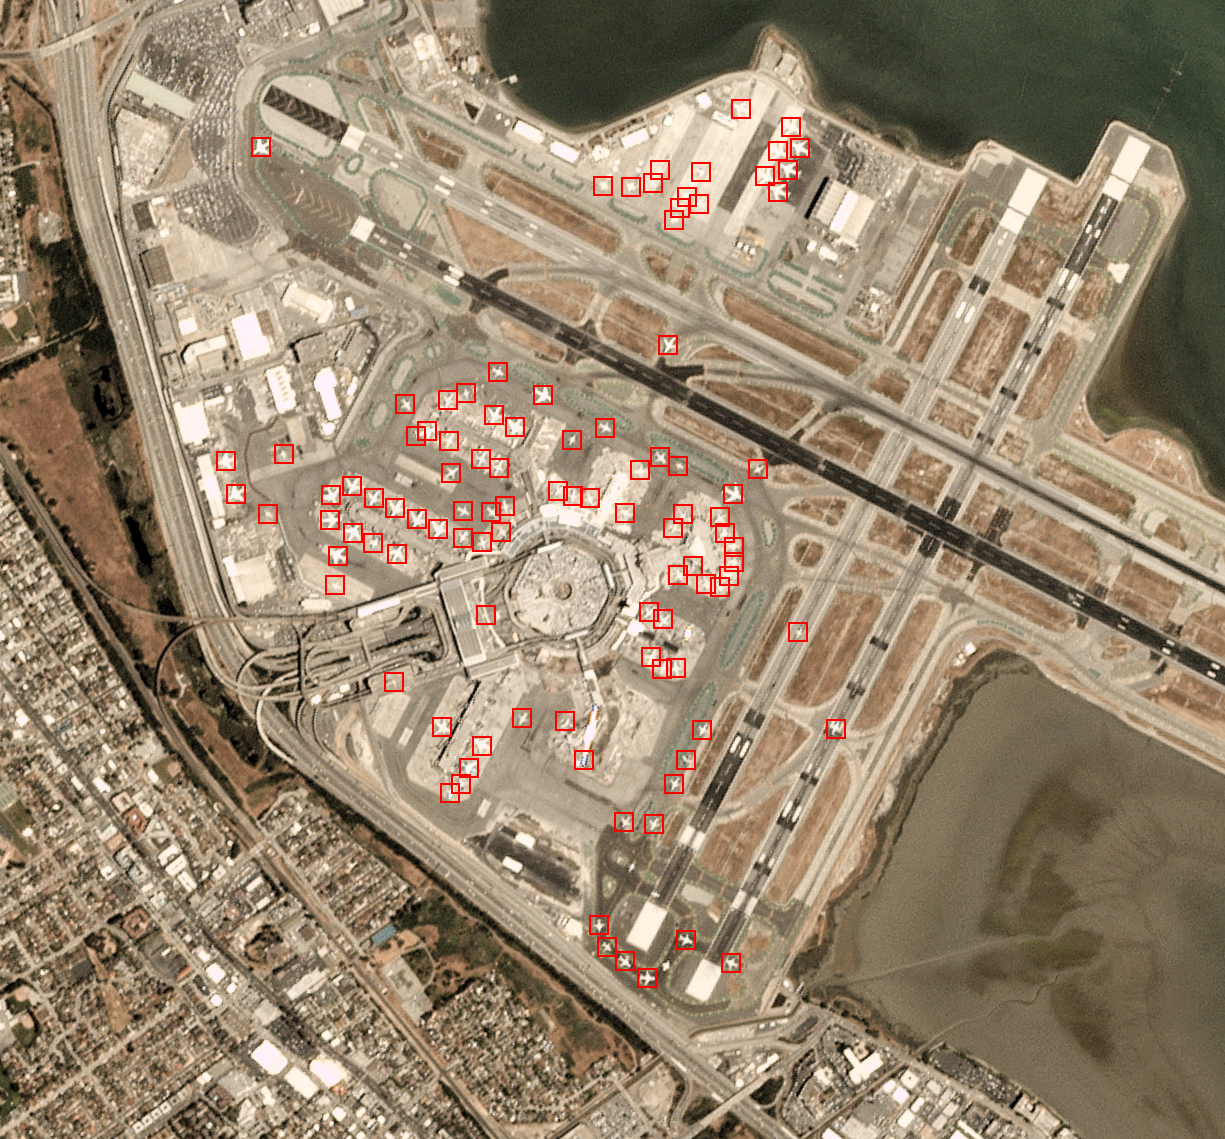

In [9]:
# Display aircraft detected from scene_1.png
from IPython.display import Image
Image("scene_1_detection.png")

In [ ]:
sess.delete_endpoint(predictor.endpoint)